In [452]:
import re
import math
import copy
import csv
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from scipy.optimize import curve_fit
import scipy.optimize as optimize

from __future__ import division

%matplotlib inline

## Read in fit results

In [453]:
fact = dict()
fact_err = dict()

In [454]:
typ = 'evgen'
factors = dict()
factors_err = dict()
input_file = 'results_cputype_task_cpu_%s_0.001.csv' % typ
with open(input_file) as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        (cpu, k, k_err) = row
        factors[cpu] = float(k)
        factors_err[cpu] = float(k_err)
fact[typ] = copy.deepcopy(factors)
fact_err[typ] = copy.deepcopy(factors_err)

In [455]:
typ = 'simul'
factors = dict()
factors_err = dict()
input_file = 'results_cputype_task_cpu_%s_0.001.csv' % typ
with open(input_file) as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        (cpu, k, k_err) = row
        factors[cpu] = float(k)
        factors_err[cpu] = float(k_err)
fact[typ] = copy.deepcopy(factors)
fact_err[typ] = copy.deepcopy(factors_err)

In [456]:
typ = 'pile'
factors = dict()
factors_err = dict()
input_file = 'results_cputype_task_cpu_%s_0.001.csv' % typ
with open(input_file) as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        (cpu, k, k_err) = row
        factors[cpu] = float(k)
        factors_err[cpu] = float(k_err)
fact[typ] = copy.deepcopy(factors)
fact_err[typ] = copy.deepcopy(factors_err)

In [457]:
typ = 'reprocessing'
factors = dict()
factors_err = dict()
input_file = 'results_cputype_task_cpu_%s_0.001.csv' % typ
with open(input_file) as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        (cpu, k, k_err) = row
        factors[cpu] = float(k)
        factors_err[cpu] = float(k_err)
fact[typ] = copy.deepcopy(factors)
fact_err[typ] = copy.deepcopy(factors_err)

In [458]:
typ = 'hc'
factors = dict()
factors_err = dict()
input_file = 'results_cputype_task_cpu_%s.csv' % typ
with open(input_file) as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        (cpu, k, k_err) = row
        factors[cpu] = float(k)
        factors_err[cpu] = float(k_err)
fact[typ] = copy.deepcopy(factors)
fact_err[typ] = copy.deepcopy(factors_err)

## Plot k factors fitted for each CPU

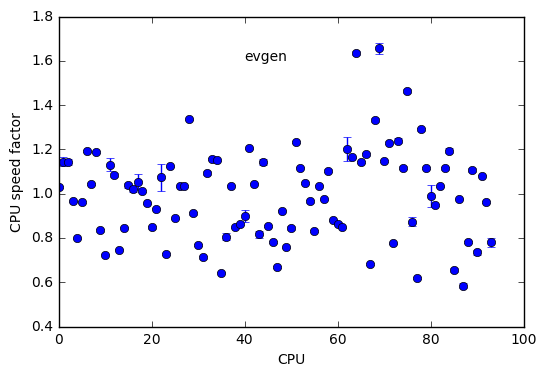

In [459]:
typ = 'evgen'

k_avg = dict()
k_std = dict()
x = list()
y = list()
yerr = list()
i = 0
for cpu in fact[typ].keys():
    x.append(i)
    y.append(fact[typ][cpu])
    yerr.append(fact_err[typ][cpu])
    i += 1
plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt='o')
plt.xlabel('CPU')
plt.ylabel('CPU speed factor')
plt.text(40., 1.6, typ)

## Load HS06 values taken from HEPSPEC web site

In [460]:
df2 = pd.read_csv('HS06_ref.txt', names=['cpu', 'hs06', 'cores', 'ht', 'ht_on', 'ht_off'])

In [512]:
len(df2)

92

In [461]:
def ht(row, s=True):
    a = row[1] / row[2]
    if row[3] == 'on':
        a_on = a
        a_off = a * 1.6
    elif row[3] == 'off':
        a_on = a / 1.6
        a_off = a
    else:
        a_on = a
        a_off = a
    if s:
        return a_on
    else:
        return a_off

df2.ht_on = df2.apply(ht, axis=1, args=(True,))
df2.ht_off = df2.apply(ht, axis=1, args=(False,))

Inspect HS06/core values

In [510]:
print "CPUs with an HS06 score:"
print len(set(df2[~np.isnan(df2.hs06)].cpu.tolist()))

CPUs with an HS06 score:
32


In [463]:
df2.ht_off.mean()

14.522945736434112

Add HS06/core values for both SMT on and off to speed factor data frame.

In [464]:
hs_on = dict()
hs_off = dict()
factors = fact[typ]
factors_err = fact_err[typ]
for row in df2.itertuples():
    cpu = row[1]
    a = row[2] / row[3]
    if row[4] == 'on':
        a_on = a
        a_off = a * 1.6
    elif row[4] == 'off':
        a_on = a / 1.6
        a_off = a
    else:
        a_on = a
        a_off = a
    for cpu2 in factors.keys():
        if cpu in cpu2:
            hs_on[cpu2] = a_on
            hs_off[cpu2] = a_off

In [465]:
df = DataFrame({'k_avg': factors, 'k_std': factors_err, 'hs_on': hs_on, 'hs_off': hs_off}).sort_values(by='k_avg', inplace=False)
df['a'] = df.k_avg / df.hs_off * 10.

## Plot factors for CPUs with HS06 data, no correction

In [466]:
def f(x, m, s, n):
    return n / (s * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s**2))

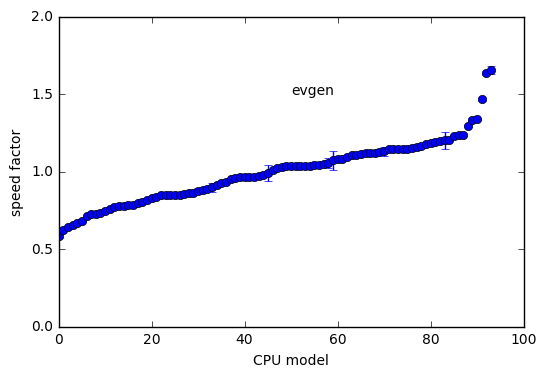

In [467]:
x = range(len(df))
y = df.k_avg
y_err = df.k_std
plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.ylim([0., 2.])
plt.xlabel('CPU model')
plt.ylabel('speed factor')
plt.text(50., 1.5, typ)

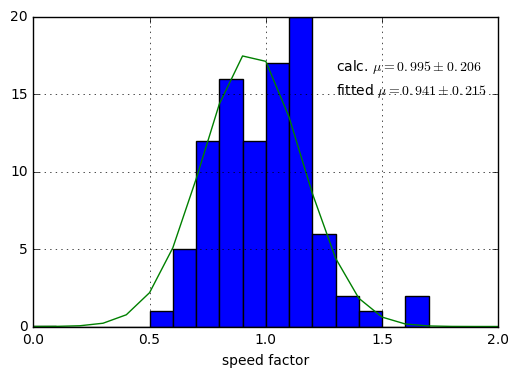

In [468]:
t, s = np.histogram(y, bins=20, range=[0., 2.])
y.hist(bins=20, range=[0., 2])
(m, si, n), _ = optimize.curve_fit(f, s[:-1], t.tolist())
plt.plot(s, f(s, m, si, n))
plt.xlabel('speed factor')
plt.text(1.3, 16.5, r'calc. $\mu=%.3f\pm%.3f$' % (y.mean(), y.std()))
plt.text(1.3, 15., r'fitted $\mu=%.3f\pm%.3f$' % (m, si))

## Plot factors for CPUs with HS06 data, with correction

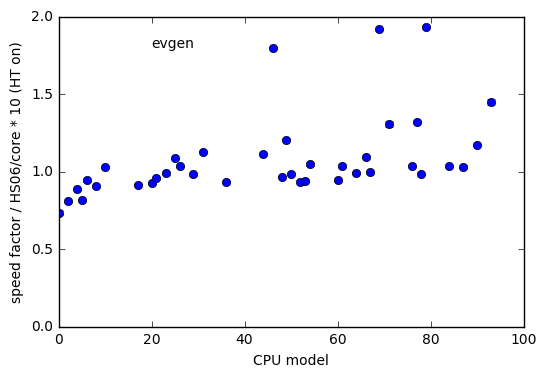

In [469]:
x = range(len(df))
y = df.k_avg / df.hs_on * 10.
y_err = df.k_std / df.hs_on * 10.
plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.ylim([0., 2.0])
plt.text(20., 1.8, typ)
plt.xlabel('CPU model')
plt.ylabel('speed factor / HS06/core * 10 (HT on)')

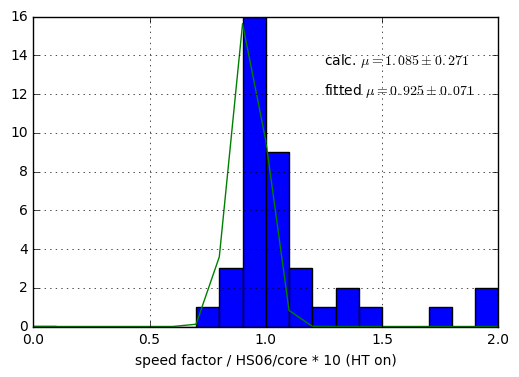

In [470]:
t, s = np.histogram(y, bins=20, range=[0., 2.])
y.hist(bins=20, range=[0., 2])
(m, si, n), _ = optimize.curve_fit(f, s[:-1], t.tolist(), p0=(1., 0.2, 1.))
plt.plot(s, f(s, m, si, n))
plt.text(1.25, 13.5, r'calc. $\mu=%.3f\pm%.3f$' % (y.mean(), y.std()))
plt.text(1.25, 12., r'fitted $\mu=%.3f\pm%.3f$' % (m, si))
plt.xlabel('speed factor / HS06/core * 10 (HT on)')

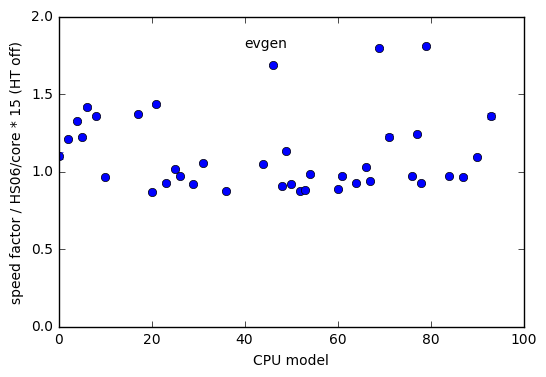

In [471]:
x = range(len(df))
y = df.k_avg / df.hs_off * 15.
y_err = df.k_std / df.hs_off * 15.
plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.ylim([0., 2.])
plt.text(40., 1.8, typ)
plt.xlabel('CPU model')
plt.ylabel('speed factor / HS06/core * 15 (HT off)')

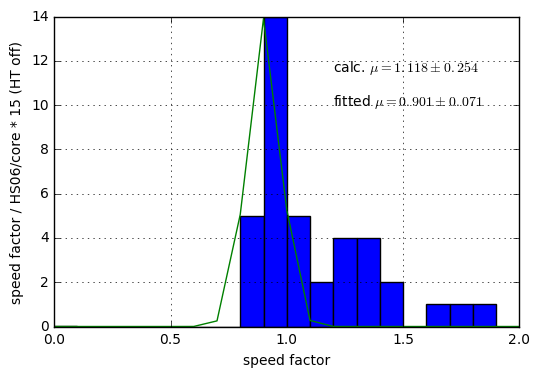

In [472]:
t, s = np.histogram(y, bins=20, range=[0., 2.])
y.hist(bins=20, range=[0., 2])
(m, si, n), _ = optimize.curve_fit(f, s[:-1], t.tolist())
plt.plot(s, f(s, m, si, n))
plt.text(1.2, 11.5, r'calc. $\mu=%.3f\pm%.3f$' % (y.mean(), y.std()))
plt.text(1.2, 10., r'fitted $\mu=%.3f\pm%.3f$' % (m, si))
plt.xlabel('speed factor')
plt.ylabel('speed factor / HS06/core * 15 (HT off)')

## Plot correlation between CPU speed factors and HS06/core

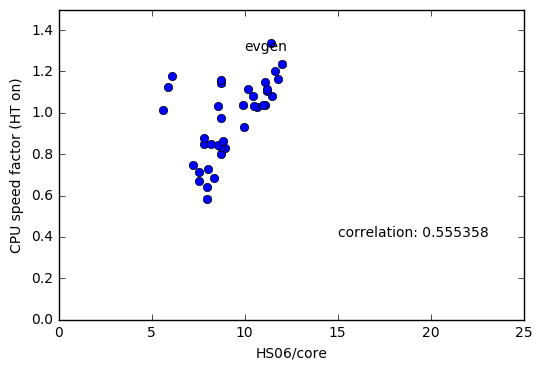

In [498]:
x = df.hs_on
y = df.k_avg
x1 = df[~np.isnan(df.hs_on)].hs_on
y1 = df[~np.isnan(df.hs_on)].k_avg
c = np.corrcoef(x1, y1, 1)
y_err = df.k_std
plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.xlabel('HS06/core')
plt.ylabel('CPU speed factor (HT on)')
plt.xlim([0., 25.])
plt.ylim([0., 1.5])
plt.text(10., 1.3, typ)
plt.text(15., 0.4, r'correlation: %f' % c[0][1])

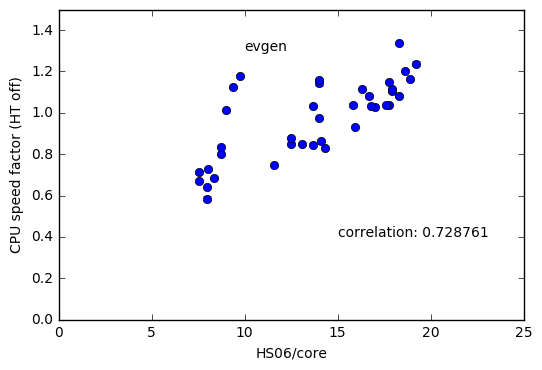

In [499]:
x = df.hs_off
y = df.k_avg
x1 = df[~np.isnan(df.hs_on)].hs_off
y1 = df[~np.isnan(df.hs_on)].k_avg
c = np.corrcoef(x1, y1, 1)
y_err = df.k_std
plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.xlabel('HS06/core')
plt.ylabel('CPU speed factor (HT off)')
plt.xlim([0., 25.])
plt.ylim([0., 1.5])
plt.text(10., 1.3, typ)
plt.text(15., 0.4, r'correlation: %f' % c[0][1])

In [451]:
def f(x, a, b):
    return a * x + b

res = curve_fit(f, x1, y1)

print "The slope of the linear fit is %f +- %f" % (res[0][0], np.sqrt(res[1][0][0]))
print "The intercept of the linear fit is %f +- %f" % (res[0][1], np.sqrt(res[1][1][1]))

The slope of the linear fit is 0.039948 +- 0.006171
The intercept of the linear fit is 0.434241 +- 0.088702


## Plot correlation between factors for evgen and simul

78.3610785373


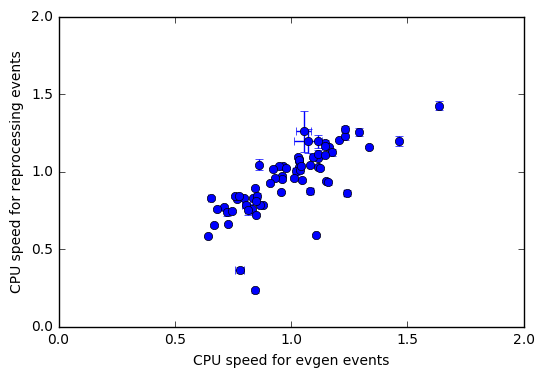

In [433]:
type1 = 'evgen'
type2 = 'reprocessing'
fact1 = fact[type1]
fact2 = fact[type2]
fact1_err = fact_err[type1]
fact2_err = fact_err[type2]
#print fact2['Intel(R) Xeon(R) CPU E5-2640 v2 @ 2.00GHz 4096 KB']
x = list()
y = list()
x_err = list()
y_err = list()
s1 = set(fact1.keys())
s2 = set(fact2.keys())
s = s2.intersection(s1)
for cpu in s:
#    print '%s\t%s\t%s' % (cpu, fact1[cpu], fact2[cpu])
    x.append(fact1[cpu])
    x_err.append(fact1_err[cpu])
    y.append(fact2[cpu])
    y_err.append(fact2_err[cpu])
plt.xlim([0., 2.])
plt.ylim([0., 2.])
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o')
plt.xlabel('CPU speed for %s events' % type1)
plt.ylabel('CPU speed for %s events' % type2)
print np.nansum(fact2.values())

In [434]:
print np.corrcoef(x, y, 0)

[[ 1.          0.75384414]
 [ 0.75384414  1.        ]]


## Fit to a straight line

In [413]:
def f(x, a, b):
    return a * x + b

res = curve_fit(f, x, y)

print "The slope of the linear fit is %f +- %f" % (res[0][0], np.sqrt(res[1][0][0]))
print "The intercept of the linear fit is %f +- %f" % (res[0][1], np.sqrt(res[1][1][1]))

The slope of the linear fit is 0.816472 +- 0.086299
The intercept of the linear fit is 0.141810 +- 0.086985


0.0494934139137


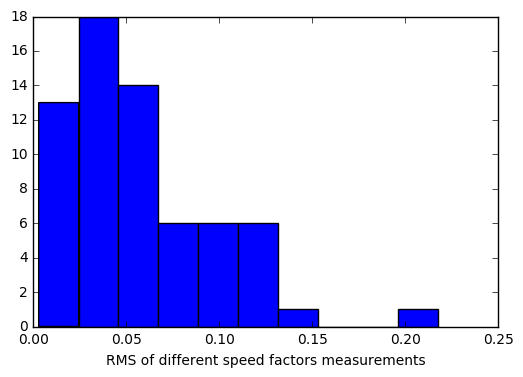

In [427]:
types = ['evgen', 'simul', 'pile', 'reprocessing', 'hc']
types = ['evgen', 'simul', 'pile', 'reprocessing']
types = ['evgen', 'simul', 'pile']
s = set(fact[types[0]].keys())
stds = list()
for typ in types:
    f = fact[typ]
    s = s.intersection(set(f.keys()))
for cpu in s:
    x = [fact[typ][cpu] for typ in types]
    stds.append(np.std(x))
print np.median(stds)
plt.hist(stds)
plt.xlabel('RMS of different speed factors measurements')